In [1]:
import obspy 
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from obspy.geodetics.base import gps2dist_azimuth as epi
from obspy.geodetics import kilometer2degrees as k2d
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt,rotate_zne_lqt
import numpy as np
client = Client('IRIS')
tpmodel = TauPyModel(model='iasp91')

In [38]:
def SNRwindow(arr_t):
    signalbegin = arr_t -5
    signalend   = arr_t +25
    noiseend    = arr_t -20 
    noisebegin  = arr_t -20-60
    return signalbegin,signalend,noiseend,noisebegin

def calSNR(tr,sbegin,send,nbegin,nend,eq_time):
    from obspy import Trace
    from obspy.signal.filter import envelope
    temp_tr = Trace(data=tr.data)
    temp_tr.stats.delta = tr.stats.delta
    temp_tr.stats.starttime = tr.stats.starttime

    noise = temp_tr.slice(starttime=eq_time+nbegin,endtime=eq_time+nend)
    signal = temp_tr.slice(starttime=eq_time+sbegin ,endtime = eq_time+send)
    signal_envelope = envelope(signal.data)
    noise_envelope = envelope(noise.data)

    cal_signal = sum(signal_envelope**2)
    cal_noise = sum(noise_envelope**2)

    SNR = int(cal_signal * 2 / cal_noise)
    return  SNR

In [150]:
t1= UTCDateTime('20130717023743')
net = 'GO'
sta = 'ONI'
loc = '*'
cha = 'HH?'
phase = ['SKS']
align = 'NEZ' #'NEZ' 
new_sr=10
freqband=[[0.04,0.125],
          [0.04,0.2],
          [0.05,0.125],
          [0.05,0.2]]


In [141]:
Cata = client.get_events(starttime=t1, endtime=t1+60, minmagnitude=6)
print(Cata)
evtime= Cata[0].origins[0].time
evlon= Cata[0].origins[0].longitude
evlat= Cata[0].origins[0].latitude
depth= Cata[0].origins[0].depth/1000
mag  = Cata[0].magnitudes[0].mag


1 Event(s) in Catalog:
2013-07-17T02:37:43.740000Z | -15.666,  -71.746 | 6.0 MW


In [142]:
yy = evtime.year
mmm = evtime.julday
hh = evtime.hour
mm = evtime.minute
savedir = f'/Volumes/home/Research/STEP/SKSwaveform/{yy}{mmm}{hh}{mm}'
from obspy import read
SAC_st = read(f'{savedir}/*BHR')
picktime = SAC_st[0].stats.sac.t0

In [143]:
inventory = client.get_stations(network=net, station=sta,
                                starttime=evtime ,
                                endtime=evtime+30*60)

stlat = inventory[0][0].latitude
stlon = inventory[0][0].longitude
stele = inventory[0][0].elevation


In [147]:
ori_st = client.get_waveforms(net, sta, loc, cha, evtime, evtime+30*60)
print(ori_st)

3 Trace(s) in Stream:
GO.ONI..HHE | 2013-07-17T02:37:43.740000Z - 2013-07-17T03:07:43.740000Z | 100.0 Hz, 180001 samples
GO.ONI..HHN | 2013-07-17T02:37:43.740000Z - 2013-07-17T03:07:43.740000Z | 100.0 Hz, 180001 samples
GO.ONI..HHZ | 2013-07-17T02:37:43.740000Z - 2013-07-17T03:07:43.740000Z | 100.0 Hz, 180001 samples


In [148]:
epi_dist, azi, baz = epi(evlat, evlon, stlat, stlon)
epi_dist /= 1000
gac = k2d(epi_dist)

arrivals = tpmodel.get_travel_times(distance_in_degree=gac, source_depth_in_km=depth, phase_list=phase)
arrival = arrivals[0]
arr_time= arrival.time
arr_slow = arrival.ray_param_sec_degree/111
arr_inc = arrival.incident_angle

In [151]:
st = ori_st.copy()
st.filter('lowpass', freq=0.5*new_sr, corners=2, zerophase=True)
st.resample(new_sr, no_filter=False)
st.detrend('linear')
st.detrend('demean')

fil_st = st.copy()
fil_st.filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
if align == '12Z':
    st.select(component='2')[0].stats.channel = st.select(component='2')[0].stats.channel[:-1]+'E'
    st.select(component='1')[0].stats.channel = st.select(component='1')[0].stats.channel[:-1]+'N'
    trE = fil_st.select(component='2')[0].copy()
    trN = fil_st.select(component='1')[0].copy()
    trZ = fil_st.select(component='Z')[0].copy()
    trN.stats.channel = trN.stats.channel[:-1] + 'N'
    trE.stats.channel = trE.stats.channel[:-1] + 'E'
elif align == 'NEZ':
    trE = fil_st.select(component='E')[0].copy()
    trN = fil_st.select(component='N')[0].copy()
    trZ = fil_st.select(component='Z')[0].copy()

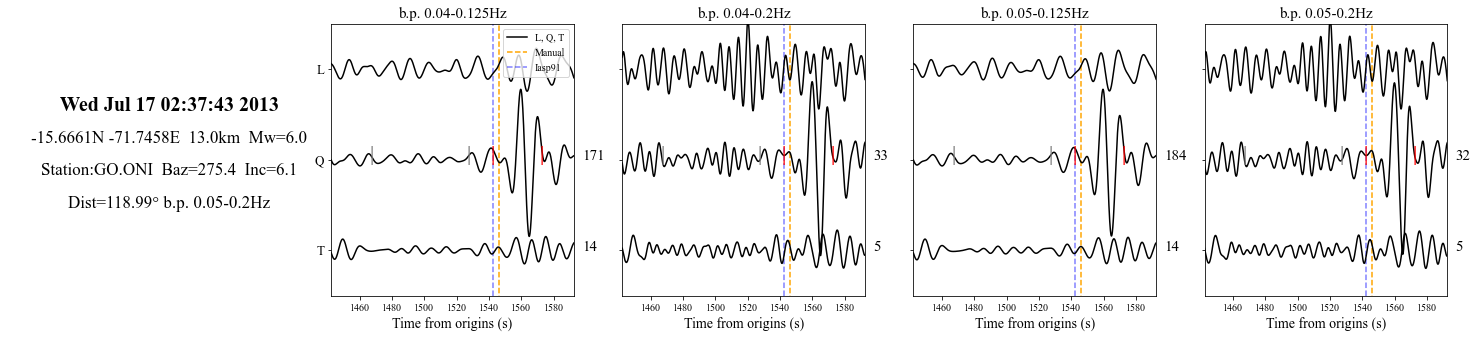

In [152]:
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(1,4, figsize = (20,5))
times = trE.times(reftime=evtime)
pmax = max(max(abs(trE.data)),max(abs(trN.data)),max(abs(trZ.data)))
for i,f in enumerate(freqband):
    fmin = f[0]; fmax=f[1]
    rotRT_st = st.copy()
    st_ZRT= rotRT_st.rotate('NE->RT', back_azimuth=baz)
    st_ZRT.filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
    ZRT_R = st_ZRT.select(component='R')[0].copy()
    ZRT_Z = st_ZRT.select(component='Z')[0].copy()
    ZRT_T = st_ZRT.select(component='T')[0].copy()


    rotQT_st = st.copy()
    st_LQT = rotQT_st.rotate('ZNE->LQT', back_azimuth=baz, inclination=arr_inc)#arr_inc)
    st_LQT.filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
    LQT_L = st_LQT.select(component='L')[0].copy()
    LQT_Q = st_LQT.select(component='Q')[0].copy()
    LQT_T = st_LQT.select(component='T')[0].copy()

    sbegin,send,nend,nbegin = SNRwindow(picktime)
    SNR_Q = calSNR(LQT_Q,sbegin,send,nbegin,nend,evtime)
    SNR_T = calSNR(LQT_T,sbegin,send,nbegin,nend,evtime)
    ax[i].text(sbegin,1,'|',color='r',fontsize=20,weight='bold')
    ax[i].text(send,1,'|',color='r',fontsize=20,weight='bold')
    ax[i].text(nbegin,1,'|',color='grey',fontsize=20,weight='bold')
    ax[i].text(nend,1,'|',color='grey',fontsize=20,weight='bold')
    ax[i].vlines(x=picktime,ymin=-1,ymax=3,color='orange',ls='--',label='Manual')
    ax[i].vlines(x=arr_time,ymin=-0.5,ymax=2.5,color='b',ls='--',alpha=0.5,label='Iasp91')
    ax[i].plot(times,LQT_Q.data/pmax+1,'k',label='L, Q, T')
    ax[i].plot(times,LQT_T.data/pmax,'k')
    ax[i].plot(times,LQT_L.data/pmax+2,'k')
    ax[i].text(arr_time+55,1,SNR_Q,fontsize=15)
    ax[i].text(arr_time+55,0,SNR_T,fontsize=15)
    # ax.legend(loc=1)
    ax[i].set_xlim(arr_time-100,arr_time+50)
    ax[i].set_ylim(-0.5,2.5)
    ax[i].set_yticks(np.arange(0,3,1))
    ax[i].set_title(f'b.p. {fmin}-{fmax}Hz',fontsize=15)
    ax[i].set_yticklabels([])
    ax[i].set_xlabel('Time from origins (s)',fontsize=14)
ax[0].set_yticklabels(['T','Q','L'],fontsize=13)
ax[0].legend(loc=1)
axt = fig.add_axes([-0.1,0.1,0.225,0.6])
axt.axis('off')
axt.text(0.5,0.9, f'{evtime.ctime()}', ha='center',weight='bold',fontsize=20)
axt.text(0.5,0.75, f'{evlat}N {evlon}E  {depth}km  Mw={mag}', ha='center',fontsize=17)
axt.text(0.5,0.6, f'Station:{net}.{sta}  Baz={round(baz,1)}  Inc={round(arr_inc,1)}', ha='center',fontsize=17)
axt.text(0.5,0.45, f'Dist={round(gac,2)}° b.p. {fmin}-{fmax}Hz', ha='center',fontsize=17)

fig.savefig(f'{savedir}/{net}.{sta}.{loc}_LQT_freqband_SNR.png',dpi=150, bbox_inches='tight')